In [1]:
datasetName = 'brain_AdultCerebellum1_Guo2020'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/brain_AdultCerebellum1_Guo2020")

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}


In [3]:
row.names(data.matrix) <- data.matrix[, 1]
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,AdultCerebellum_1.ACGAGCATTCCAACGTTG,AdultCerebellum_1.TGCGGACGCACCGCCTAG,AdultCerebellum_1.AACCTAACACCCAGTCGT,AdultCerebellum_1.AAGCGGCGTGGCTGATCA,AdultCerebellum_1.AACCTAGCTCAAGTGGTA
,<int>,<int>,<int>,<int>,<int>
A1BG,0,0,0,0,0
A1BG-AS1,0,0,0,0,0
A2M,1,0,13,2,0
A2M-AS1,0,0,0,0,0
A2ML1,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
AdultCerebellum_1.ACGAGCATTCCAACGTTG,brain,AdultCerebellum,AdultCerebellum,Space occupying lesion of cerebellum,Donor29,female,55 years old
AdultCerebellum_1.TGCGGACGCACCGCCTAG,brain,AdultCerebellum,AdultCerebellum,Space occupying lesion of cerebellum,Donor29,female,55 years old
AdultCerebellum_1.AACCTAACACCCAGTCGT,brain,AdultCerebellum,AdultCerebellum,Space occupying lesion of cerebellum,Donor29,female,55 years old
AdultCerebellum_1.AAGCGGCGTGGCTGATCA,brain,AdultCerebellum,AdultCerebellum,Space occupying lesion of cerebellum,Donor29,female,55 years old
AdultCerebellum_1.AACCTAGCTCAAGTGGTA,brain,AdultCerebellum,AdultCerebellum,Space occupying lesion of cerebellum,Donor29,female,55 years old


[1] Oligodendrocyte   Fetal enterocyte  Macrophage        Oligodendrocyte  
[5] Oligodendrocyte  
21 Levels: Antigen presenting cell (RPS high) Astrocyte ... T cell

In [4]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


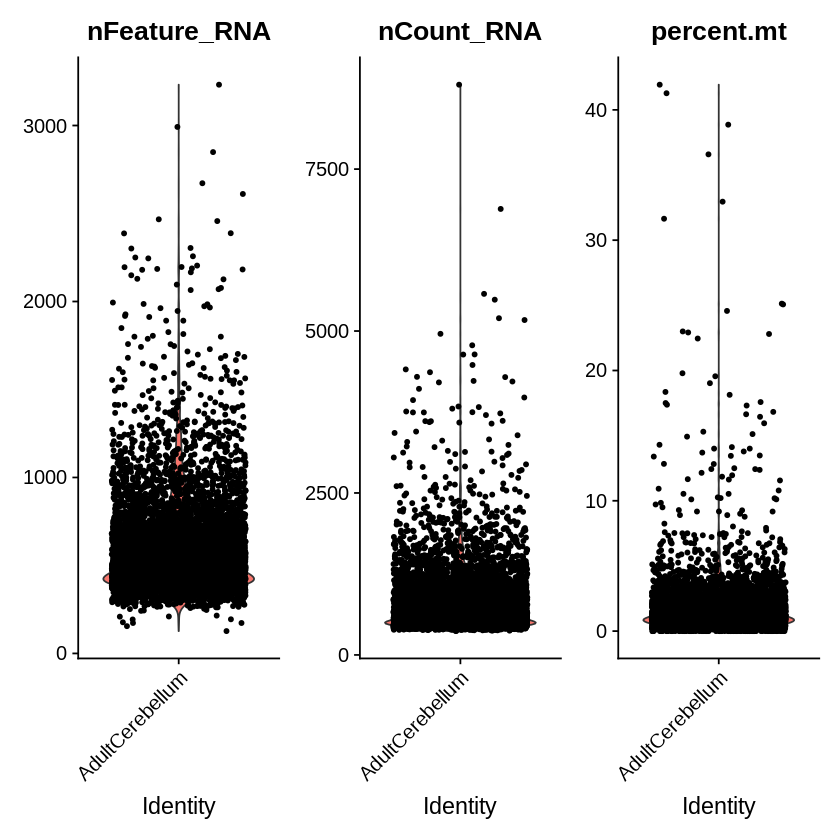

In [5]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [6]:
# QC
nFeature_RNA_range = c(200, 2500)
percent.mt.thre = 5
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)


In [7]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [8]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  CD74, FTL, TMSB4X, HLA-DRA, HLA-DRB1, CCL3, B2M, LAPTM5, HLA-DPA1, CCL3L3 
	   CCL4, CCL4L2, TYROBP, RNASET2, RGS1, FCER1G, C1QA, SRGN, AIF1, TREM2 
	   CTSB, CD14, HLA-DPB1, SAT1, C1QB, A2M, CD83, FCGR3A, TMSB10, C3 
Negative:  CRYAB, TF, SCD, MBP, CLDND1, SEPP1, PPP1R14A, QDPR, PEBP1, GPRC5B 
	   STMN4, MAG, ABCA2, CNDP1, APOD, ENPP2, MOBP, CKB, SEPW1, UBB 
	   CNTN2, CARNS1, KLK6, LHPP, NDRG2, UGT8, MT3, SIRT2, CA2, MAL 
PC_ 2 
Positive:  TF, MBP, SCD, PPP1R14A, QDPR, CLDND1, MAG, STMN4, CNDP1, MOBP 
	   ENPP2, CNTN2, ABCA2, KLK6, CARNS1, UGT8, PLEKHH1, HSPA2, APOD, ANLN 
	   DHCR24, MAL, PIP4K2A, CA2, ATP1B1, CERCAM, MYRF, GPR37, GJB1, LANCL1 
Negative:  C1orf61, SLC1A3, SCG3, MT3, ATP1A2, ALDH1A1, TUBB2B, SERPINE2, CST3, NDRG2 
	   TIMP4, CKB, SPARC, CPE, FABP7, GJA1, LCAT, LGALS3, MGST1, APOE 
	   DAO, DBI, TUBB2A, S1PR1, ATP1B2, AQP4, PEBP1, CDC42EP4, NDRG4, MLC1 
PC_ 3 
Positive:  CD74, SPP1, CCL3, HLA-DRA, CCL4, CCL4L2, CCL3L3, TREM2, FTL, SLC1A3 
	   APOE, C

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


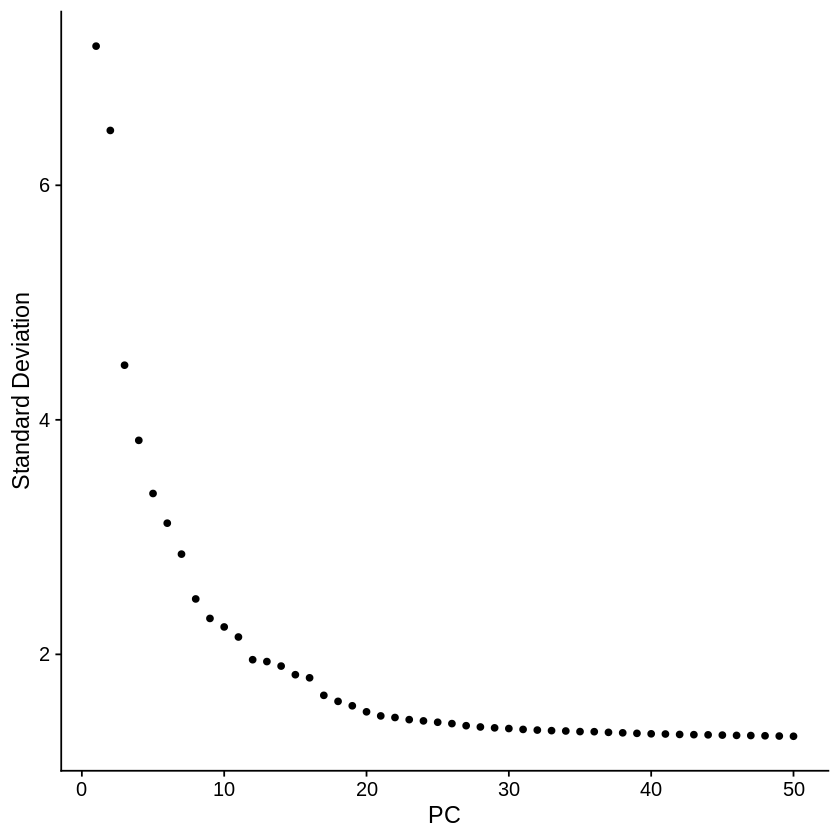

In [9]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [10]:
dev.off()
pcDim = 10 # set as 50 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
03:42:27 UMAP embedding parameters a = 0.9922 b = 1.112

03:42:27 Read 7169 rows and found 10 numeric columns

03:42:27 Using Annoy for neighbor search, n_neighbors = 30

03:42:27 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

03:42:28 Writing NN index file to temp file /tmp/Rtmp9bui0P/file102c11ddb476

03:42:28 Searching Annoy index using 1 thread, search_k = 3000

03:42:31 Annoy recall = 100%

03:42:31 Commencing smooth kNN distance calibration using 1 thread

03:42:31 Initializing fr

In [11]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.6)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 7169
Number of edges: 244868

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8997
Number of communities: 19
Elapsed time: 0 seconds


03:42:50 UMAP embedding parameters a = 0.9922 b = 1.112

03:42:50 Read 7169 rows and found 10 numeric columns

03:42:50 Using Annoy for neighbor search, n_neighbors = 30

03:42:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

03:42:51 Writing NN index file to temp file /tmp/Rtmp9bui0P/file102c20efcd8

03:42:51 Searching Annoy index using 1 thread, search_k = 3000

03:42:54 Annoy recall = 100%

03:42:54 Commencing smooth kNN distance calibration using 1 thread

03:42:55 Initializing from normalized Laplacian + noise

03:42:55 Commencing optimization for 500 epochs, with 310666 positive edges

03:43:12 Optimization finished



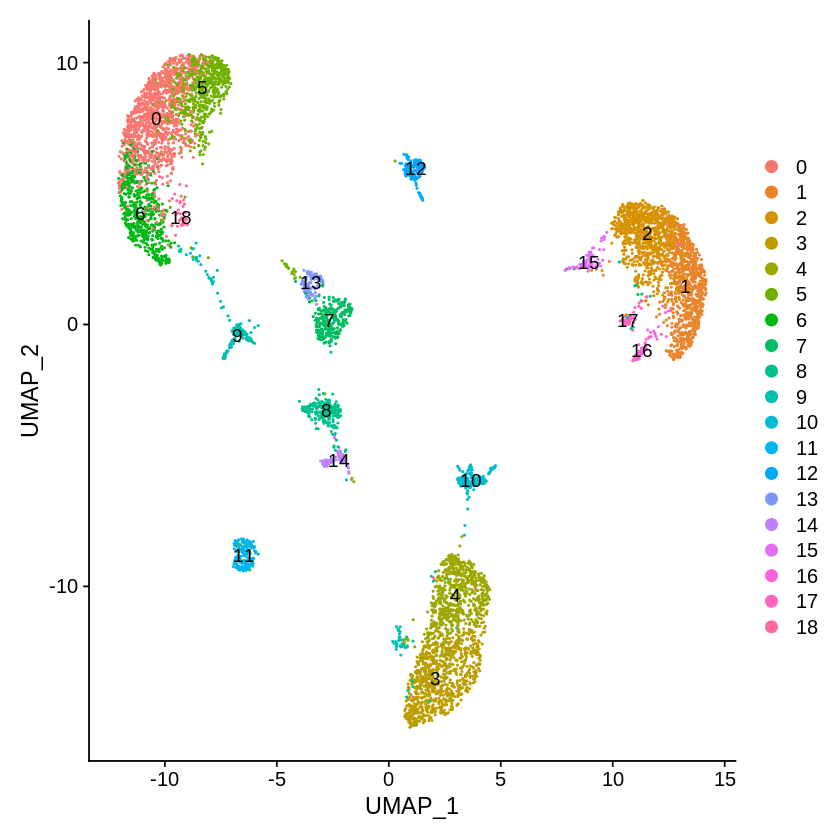

In [14]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [17]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

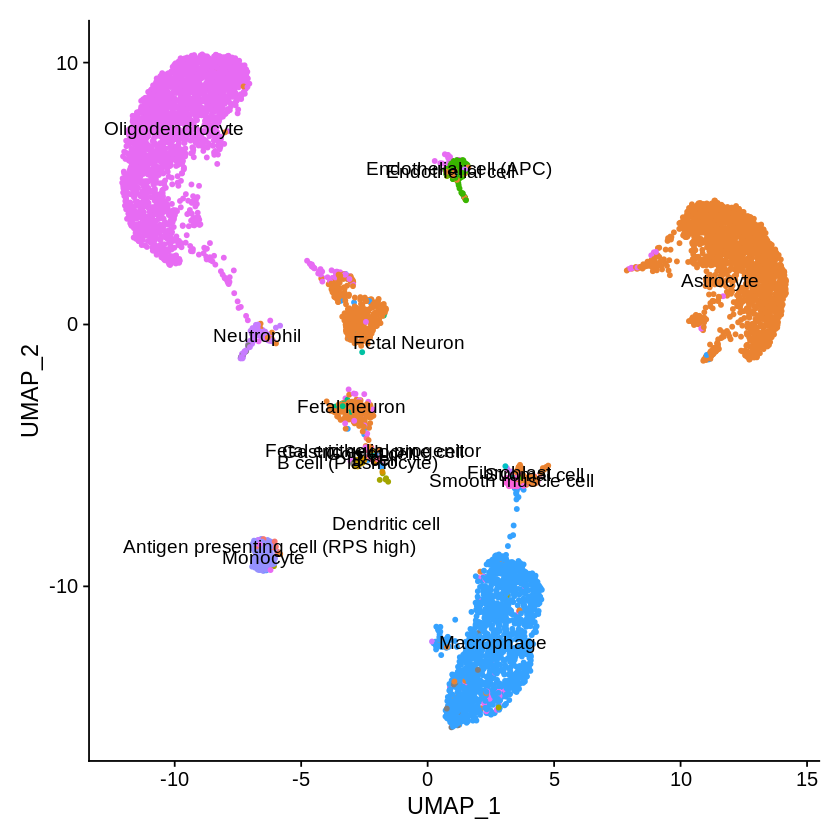

In [16]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1) + NoLegend()
p_umap2

In [18]:
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [18]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18



In [19]:
new.cluster.ids <- c('Brain-Nerve tissue-Oligodendrocyte-MBP', 'Brain-Nerve tissue-Astrocyte-ALDOC', 'Brain-Nerve tissue-Astrocyte-ALDOC',
                    'Brain-Connective tissue-Macrophage-CD14', 'Brain-Connective tissue-Macrophage-CD14', 'Brain-Nerve tissue-Oligodendrocyte-MBP',
                    'Brain-Nerve tissue-Oligodendrocyte-MBP', 'Brain-Nerve tissue-Astrocyte-ALDOC', 'Brain-Nerve tissue-Excitatory neuron-NEUROD1',
                    'Brain-Connective tissue-Neutrophil-S100A9', 'Brain-Muscle tissue-Smooth muscle cell-TAGLN', 'Brain-Connective tissue-Macrophage/Neutrophil-CD14 and S100A9',
                    'Brain-Epithelial tissue-Endothelial cell-CLDN5', 'Brain-Nerve tissue-Oligodendrocyte-MBP', 'Brain-Connective tissue-T cell/B cell-TRBC2 and IGHG4',
                    'Brain-Nerve tissue-Oligodendrocyte/Astrocyte-MBP and ALDOC', 'Brain-Nerve tissue-Astrocyte-ALDOC', 'Brain-Nerve tissue-Astrocyte/Neutrophil-ALDOC and S100A9',
                    'Brain-Nerve tissue-Oligodendrocyte-MBP')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

In [12]:
new.cluster.ids <- c('Brain-Nerve tissue-Oligodendrocyte-MBP', 'Brain-Nerve tissue-Astrocyte-ALDOC', 'Brain-Nerve tissue-Astrocyte-ALDOC',
                    'Unknown', 'Unknown', 'Brain-Nerve tissue-Oligodendrocyte-MBP',
                    'Brain-Nerve tissue-Oligodendrocyte-MBP', 'Brain-Nerve tissue-Astrocyte-ALDOC', 'Brain-Nerve tissue-Excitatory neuron-NEUROD1',
                    'Unknown', 'Unknown', 'Unknown',
                    'Brain-Epithelial tissue-Endothelial cell-CLDN5', 'Brain-Nerve tissue-Oligodendrocyte-MBP', 'Unknown',
                    'Brain-Nerve tissue-Oligodendrocyte/Astrocyte-MBP and ALDOC', 'Brain-Nerve tissue-Astrocyte-ALDOC', 'Brain-Nerve tissue-Astrocyte-ALDOC',
                    'Brain-Nerve tissue-Oligodendrocyte-MBP')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

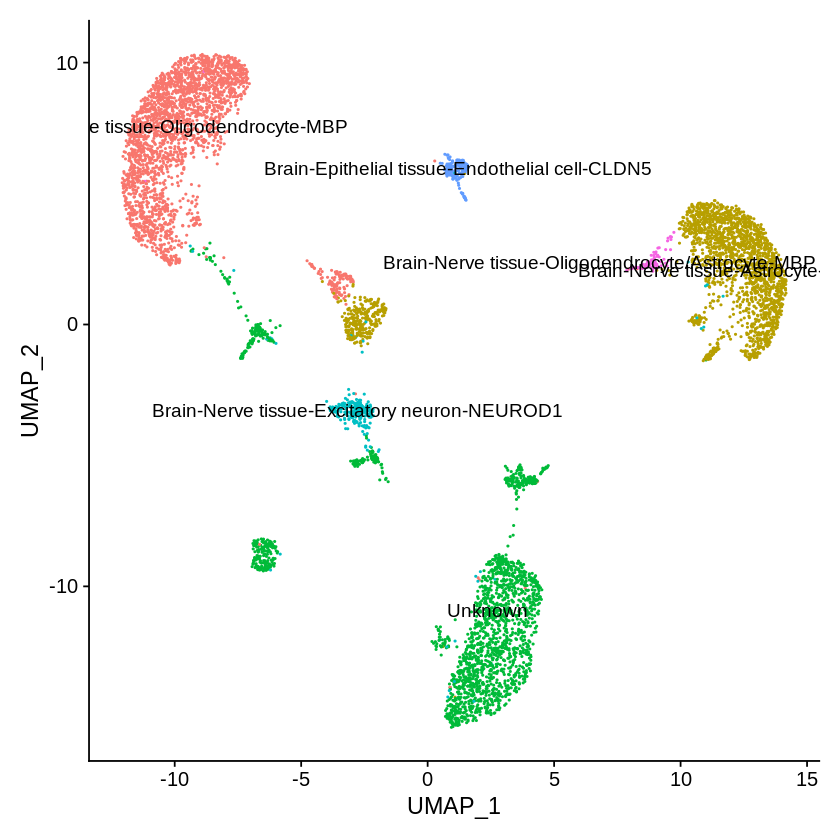

In [13]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [14]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [15]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))